In [1]:
%%capture
!pip install pandas matplotlib seaborn librosa

In [2]:
import os
import sys

PROJECT_ROOT = os.path.abspath(os.path.join(
                  os.path.dirname("eda"), 
                  os.pardir)
)
sys.path.append(PROJECT_ROOT)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import librosa
from src.utils import create_coraa_train_dataframe, create_emodb_train_dataframe, create_ravdess_train_dataframe, create_savee_train_dataframe
from typing import Dict, List

warnings.filterwarnings("ignore")
sns.set_style("darkgrid")

In [3]:
def check_sample_rates(
    df: pd.DataFrame
) -> Dict:
    """
    Checks the sample rate for each audio file within a folder
    (to see if more than one unique sample rate is found).
    
    Args:
        df (pd.DataFrame): the metadata dataframe.
    
    Returns:
        Dict: a dict which the keys are the sample rate values and its
              values are a list with the corresponding audio file name.
    """
    wav_files = df["file"].unique().tolist()
    rates = {}
    
    for wav in wav_files:
        try:
            _, sr = librosa.load(wav, mono=False, sr=None)

            if sr not in rates.keys():
                rates[sr] = [wav]
            else:
                rates[sr].append(wav)
        except:
            print(f"Error in file {wav}")
    
    return rates

def check_number_of_channels(
    df: pd.DataFrame
) -> Dict:
    """
    Checks the number of channels (stereo or mono) for each audio file
    within a folder (to see if more than one is found).
    
    Args:
        df (pd.DataFrame): the metadata dataframe.
    
    Returns:
        Dict: a dict which the keys are the channel and its
              values are a list with the corresponding audio file name.
    """
    wav_files = df["file"].unique().tolist()
    number_channels = {}
    
    for wav in wav_files:
        try:
            audio, _ = librosa.load(wav, mono=False, sr=None)
            channels = "mono" if audio.ndim == 1 else "stereo"

            if channels not in number_channels.keys():
                number_channels[channels] = [wav]
            else:
                number_channels[channels].append(wav)
        except:
            print(f"Error in file {wav}")
            
    return number_channels

def get_duration(
    df: pd.DataFrame
) -> pd.DataFrame:
    """
    Creates a new column on the dataframe containing the duration
    in seconds of each audio file.
    
    Args:
        df (pd.DataFrame): the metadata dataframe.
    
    Returns:
        pd.DataFrame: the metadata dataframe with the duration
                      of each file added.
    """
    df["duration"] = df["file"].apply(
        lambda x: librosa.get_duration(filename=x)
    )
    return df

def plot_file_duration(
    df: pd.DataFrame,
    top_n: int
) -> None:
    """
    Plot the duration of the files.
    
    Args:
        df (pd.DataFrame): the metadata dataframe.
    """
    df = df.sort_values("duration", ascending=False)
    
    if top_n > 0:
        df = df[:top_n]
    elif top_n < 0:
        df = df[top_n:]
        
    plt.figure(figsize=(6, 4))
    sns.barplot(
        data=df,
        x="wav_file",
        y="duration",
        color="cornflowerblue"
    )
    plt.xlabel("File name")
    plt.xticks(rotation=90)
    plt.ylabel("Duration (in seconds)")
    plt.title("File duration")
    plt.show()

### SAVEE

In [4]:
savee_path = "/media/greca/HD/Datasets/SAVEE/"
savee_df = create_savee_train_dataframe(savee_path)
savee_df.head()

,file,label,wav_file
0,/media/greca/HD/Datasets/SAVEE/DC_a01.wav,anger,DC_a01.wav
1,/media/greca/HD/Datasets/SAVEE/DC_n05.wav,neutral,DC_n05.wav
2,/media/greca/HD/Datasets/SAVEE/KL_n26.wav,neutral,KL_n26.wav
3,/media/greca/HD/Datasets/SAVEE/JK_n06.wav,neutral,JK_n06.wav
4,/media/greca/HD/Datasets/SAVEE/JE_d13.wav,disgust,JE_d13.wav


In [5]:
savee_rates = check_sample_rates(
    df=savee_df
)

savee_rates_unique = list(set(list(savee_rates.keys())))

if len(savee_rates_unique) == 1:
    print(f"Sample rate of {savee_rates_unique[0]} found!")
else:
    print(f"Different sample were rates found! {savee_rates_unique}")

Sample rate of 44100 found!


In [6]:
savee_num_channels = check_number_of_channels(
    df=savee_df
)

savee_unique_num_channels = list(set(list(savee_num_channels.keys())))

if len(savee_unique_num_channels) == 1:
    print(f"The files are {savee_unique_num_channels[0]}!")
else:
    print(f"Both stereo and mono audios were found!")

The files are mono!


In [7]:
savee_df["label"] = savee_df["label"].replace({
    "neutral": "neutro",
    "happiness": "felicidade",
    "sadness": "tristeza",
    "anger": "raiva",
    "fear": "medo",
    "disgust": "nojo",
    "surprise": "surpresa"
})

savee_df.head()

,file,label,wav_file
0,/media/greca/HD/Datasets/SAVEE/DC_a01.wav,raiva,DC_a01.wav
1,/media/greca/HD/Datasets/SAVEE/DC_n05.wav,neutro,DC_n05.wav
2,/media/greca/HD/Datasets/SAVEE/KL_n26.wav,neutro,KL_n26.wav
3,/media/greca/HD/Datasets/SAVEE/JK_n06.wav,neutro,JK_n06.wav
4,/media/greca/HD/Datasets/SAVEE/JE_d13.wav,nojo,JE_d13.wav


In [8]:
savee_df = get_duration(
    df=savee_df
)

print(sum(savee_df["duration"])/60)

30.715794784580492


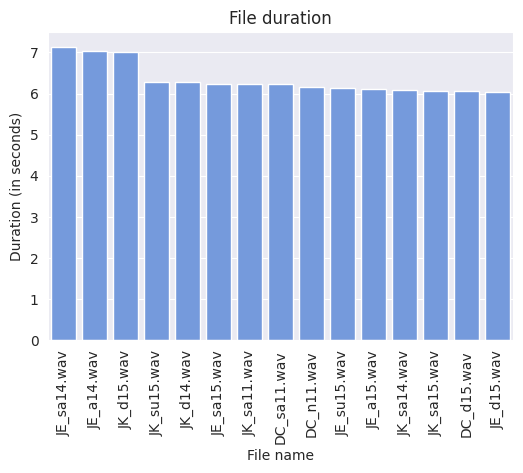

In [9]:
plot_file_duration(savee_df, top_n=15)

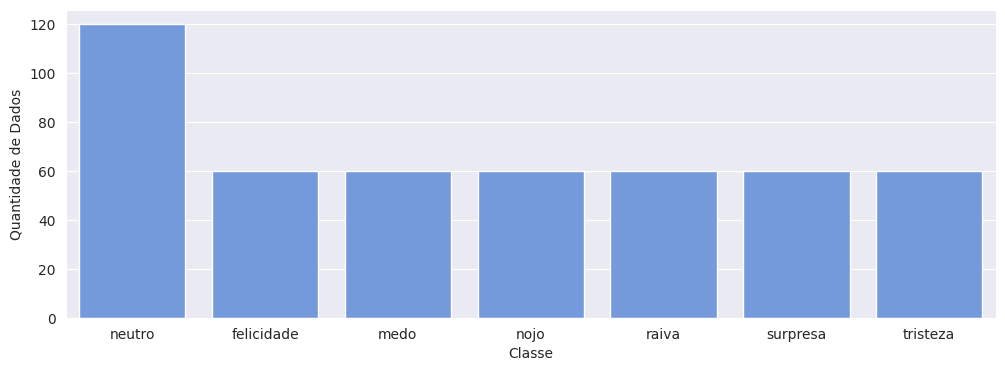

In [10]:
fig = plt.figure(figsize=(12, 4))

df_gby_train = savee_df.groupby("label").agg({"wav_file": "count"})
df_gby_train = df_gby_train.reset_index()
df_gby_train = df_gby_train.sort_values("wav_file", ascending=False)
df_gby_train = df_gby_train.reset_index()

sns.barplot(
    data=df_gby_train,
    x="label",
    y="wav_file",
    color="cornflowerblue"
)
plt.ylabel("Quantidade de Dados")
plt.xlabel("Classe")
plt.savefig("../images/distribuição_savee.png")

### RAVDESS

In [11]:
ravdess_path = "/media/greca/HD/Datasets/RAVDESS/"
ravdess_df = create_ravdess_train_dataframe(ravdess_path)
ravdess_df.head()

,file,label,wav_file
0,/media/greca/HD/Datasets/RAVDESS/Actor_01/03-0...,sad,03-01-04-02-01-01-01.wav
1,/media/greca/HD/Datasets/RAVDESS/Actor_01/03-0...,calm,03-01-02-01-01-01-01.wav
2,/media/greca/HD/Datasets/RAVDESS/Actor_01/03-0...,surprised,03-01-08-01-01-01-01.wav
3,/media/greca/HD/Datasets/RAVDESS/Actor_01/03-0...,surprised,03-01-08-01-01-02-01.wav
4,/media/greca/HD/Datasets/RAVDESS/Actor_01/03-0...,surprised,03-01-08-02-01-02-01.wav


In [12]:
ravdess_rates = check_sample_rates(
    df=ravdess_df
)

ravdess_rates_unique = list(set(list(ravdess_rates.keys())))

if len(ravdess_rates_unique) == 1:
    print(f"Sample rate of {ravdess_rates_unique[0]} found!")
else:
    print(f"Different sample were rates found! {ravdess_rates_unique}")

Sample rate of 48000 found!


In [13]:
ravdess_num_channels = check_number_of_channels(
    df=ravdess_df
)

ravdess_unique_num_channels = list(set(list(ravdess_num_channels.keys())))

if len(ravdess_unique_num_channels) == 1:
    print(f"The files are {ravdess_unique_num_channels[0]}!")
else:
    print(f"Both stereo and mono audios were found!")

Both stereo and mono audios were found!


In [14]:
ravdess_df["label"] = ravdess_df["label"].replace({
    "neutral": "neutro",
    "calm": "calmo",
    "happy": "felicidade",
    "sad": "tristeza",
    "angry": "raiva",
    "fearful": "medo",
    "disgust": "nojo",
    "surprised": "surpresa"
})

ravdess_df.head()

,file,label,wav_file
0,/media/greca/HD/Datasets/RAVDESS/Actor_01/03-0...,tristeza,03-01-04-02-01-01-01.wav
1,/media/greca/HD/Datasets/RAVDESS/Actor_01/03-0...,calmo,03-01-02-01-01-01-01.wav
2,/media/greca/HD/Datasets/RAVDESS/Actor_01/03-0...,surpresa,03-01-08-01-01-01-01.wav
3,/media/greca/HD/Datasets/RAVDESS/Actor_01/03-0...,surpresa,03-01-08-01-01-02-01.wav
4,/media/greca/HD/Datasets/RAVDESS/Actor_01/03-0...,surpresa,03-01-08-02-01-02-01.wav


In [15]:
ravdess_df = get_duration(
    df=ravdess_df
)

print(sum(ravdess_df["duration"])/60)

88.81595555555542


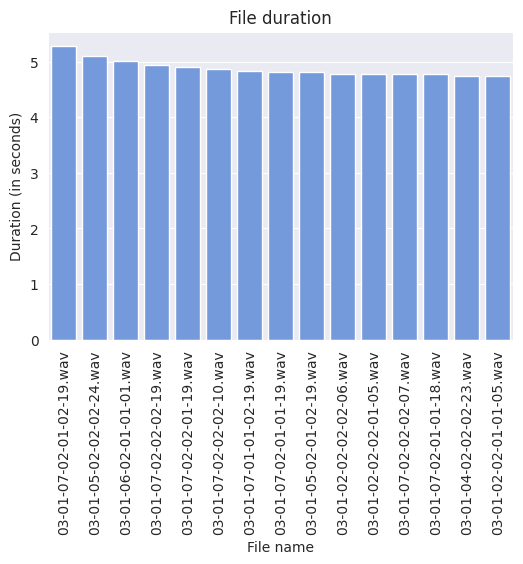

In [16]:
plot_file_duration(ravdess_df, top_n=15)

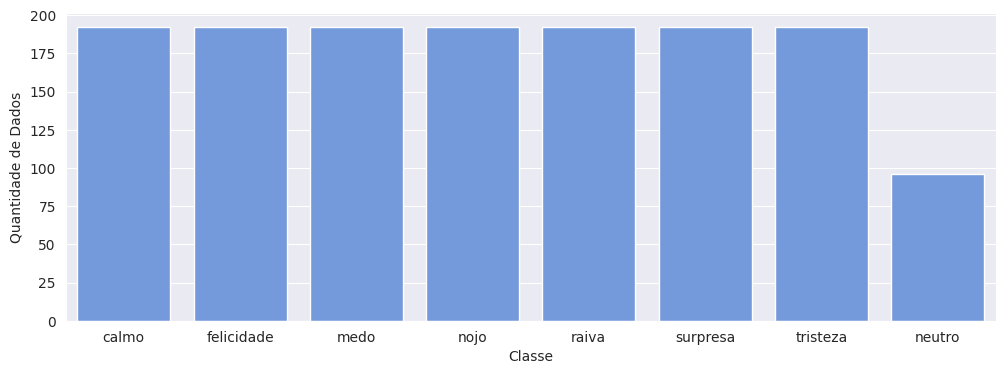

In [17]:
fig = plt.figure(figsize=(12, 4))

df_gby_train = ravdess_df.groupby("label").agg({"wav_file": "count"})
df_gby_train = df_gby_train.reset_index()
df_gby_train = df_gby_train.sort_values("wav_file", ascending=False)
df_gby_train = df_gby_train.reset_index()

sns.barplot(
    data=df_gby_train,
    x="label",
    y="wav_file",
    color="cornflowerblue"
)
plt.ylabel("Quantidade de Dados")
plt.xlabel("Classe")
plt.savefig("../images/distribuição_ravdess.png")

### EmoDB

In [18]:
emodb_path = "/media/greca/HD/Datasets/EmoDB/"
emodb_df = create_emodb_train_dataframe(emodb_path)
emodb_df.head()

,file,label,wav_file
0,/media/greca/HD/Datasets/EmoDB/wav/10b02La.wav,boredom,10b02La.wav
1,/media/greca/HD/Datasets/EmoDB/wav/16b09Eb.wav,disgust,16b09Eb.wav
2,/media/greca/HD/Datasets/EmoDB/wav/12a01Wc.wav,anger,12a01Wc.wav
3,/media/greca/HD/Datasets/EmoDB/wav/15a01Nb.wav,neutral,15a01Nb.wav
4,/media/greca/HD/Datasets/EmoDB/wav/08b03Nb.wav,neutral,08b03Nb.wav


In [19]:
emodb_rates = check_sample_rates(
    df=emodb_df
)

emodb_rates_unique = list(set(list(emodb_rates.keys())))

if len(emodb_rates_unique) == 1:
    print(f"Sample rate of {emodb_rates_unique[0]} found!")
else:
    print(f"Different sample were rates found! {emodb_rates_unique}")

Sample rate of 16000 found!


In [20]:
emodb_num_channels = check_number_of_channels(
    df=emodb_df
)

emodb_unique_num_channels = list(set(list(emodb_num_channels.keys())))

if len(emodb_unique_num_channels) == 1:
    print(f"The files are {emodb_unique_num_channels[0]}!")
else:
    print(f"Both stereo and mono audios were found!")

The files are mono!


In [21]:
emodb_df["label"] = emodb_df["label"].replace({
    "neutral": "neutro",
    "anger": "raiva",
    "boredom": "tédio",
    "disgust": "nojo",
    "anxiety/fear": "medo",
    "happiness": "felicidade",
    "sadness": "tristeza"
})

emodb_df.head()

,file,label,wav_file
0,/media/greca/HD/Datasets/EmoDB/wav/10b02La.wav,tédio,10b02La.wav
1,/media/greca/HD/Datasets/EmoDB/wav/16b09Eb.wav,nojo,16b09Eb.wav
2,/media/greca/HD/Datasets/EmoDB/wav/12a01Wc.wav,raiva,12a01Wc.wav
3,/media/greca/HD/Datasets/EmoDB/wav/15a01Nb.wav,neutro,15a01Nb.wav
4,/media/greca/HD/Datasets/EmoDB/wav/08b03Nb.wav,neutro,08b03Nb.wav


In [22]:
emodb_df = get_duration(
    df=emodb_df
)

print(sum(emodb_df["duration"])/60)

24.784869791666672


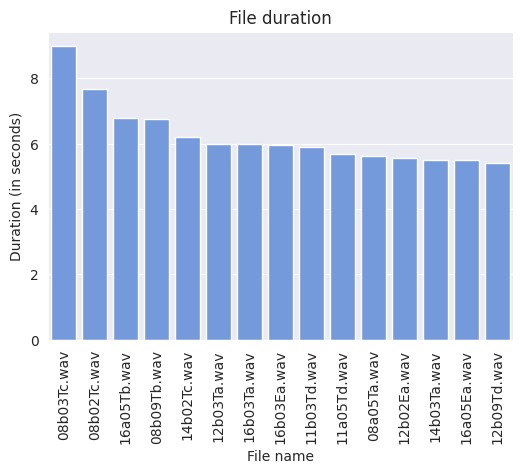

In [23]:
plot_file_duration(emodb_df, top_n=15)

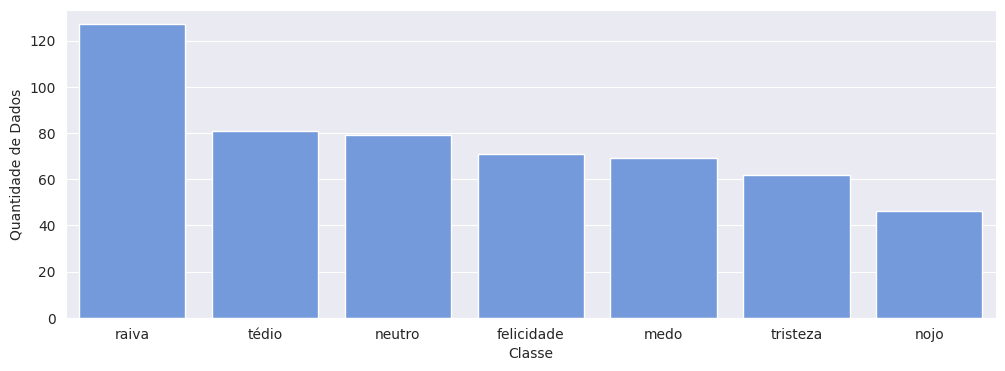

In [24]:
fig = plt.figure(figsize=(12, 4))

df_gby_train = emodb_df.groupby("label").agg({"wav_file": "count"})
df_gby_train = df_gby_train.reset_index()
df_gby_train = df_gby_train.sort_values("wav_file", ascending=False)
df_gby_train = df_gby_train.reset_index()

sns.barplot(
    data=df_gby_train,
    x="label",
    y="wav_file",
    color="cornflowerblue"
)
plt.ylabel("Quantidade de Dados")
plt.xlabel("Classe")
plt.savefig("../images/distribuição_emodb.png")

### CORAA

In [25]:
propor_train_path = "/media/greca/HD/Datasets/PROPOR 2022/"
propor_train_df = create_coraa_train_dataframe(propor_train_path)
propor_train_df.head()

,file,label,wav_file
0,/media/greca/HD/Datasets/PROPOR 2022/data_trai...,non-neutral-male,bpubdl02_segment247_non-neutral-male.wav
1,/media/greca/HD/Datasets/PROPOR 2022/data_trai...,neutral,bpubmn14_segment89_neutral.wav
2,/media/greca/HD/Datasets/PROPOR 2022/data_trai...,neutral,bfamdl26_segment93_neutral.wav
3,/media/greca/HD/Datasets/PROPOR 2022/data_trai...,neutral,bfammn27_segment275_neutral.wav
4,/media/greca/HD/Datasets/PROPOR 2022/data_trai...,neutral,bfamcv02_segment276_neutral.wav


In [26]:
propor_rates = check_sample_rates(
    df=propor_train_df
)

propor_rates_unique = list(set(list(propor_rates.keys())))

if len(propor_rates_unique) == 1:
    print(f"Sample rate of {propor_rates_unique[0]} found!")
else:
    print(f"Different sample were rates found! {propor_rates_unique}")

Sample rate of 16000 found!


In [27]:
propor_num_channels = check_number_of_channels(
    df=propor_train_df
)

propor_unique_num_channels = list(set(list(propor_num_channels.keys())))

if len(propor_unique_num_channels) == 1:
    print(f"The files are {propor_unique_num_channels[0]}!")
else:
    print(f"Both stereo and mono audios were found!")

The files are mono!


In [28]:
propor_train_df["label"] = propor_train_df["label"].replace({
    "neutral": "neutro",
    "non-neutral-male": "homem não-neutro",
    "non-neutral-female": "mulher não-neutro"
})

propor_train_df.head()

,file,label,wav_file
0,/media/greca/HD/Datasets/PROPOR 2022/data_trai...,homem não-neutro,bpubdl02_segment247_non-neutral-male.wav
1,/media/greca/HD/Datasets/PROPOR 2022/data_trai...,neutro,bpubmn14_segment89_neutral.wav
2,/media/greca/HD/Datasets/PROPOR 2022/data_trai...,neutro,bfamdl26_segment93_neutral.wav
3,/media/greca/HD/Datasets/PROPOR 2022/data_trai...,neutro,bfammn27_segment275_neutral.wav
4,/media/greca/HD/Datasets/PROPOR 2022/data_trai...,neutro,bfamcv02_segment276_neutral.wav


In [29]:
propor_train_df = get_duration(
    df=propor_train_df
)

print(sum(propor_train_df["duration"])/60)

39.37970520833338


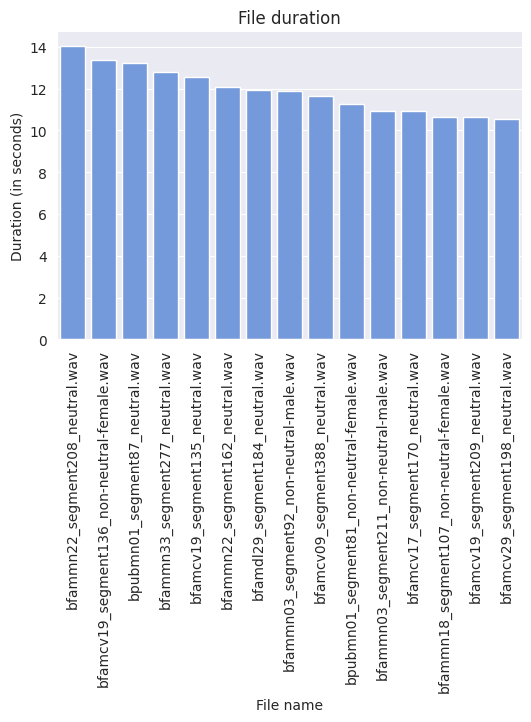

In [30]:
plot_file_duration(propor_train_df, top_n=15)

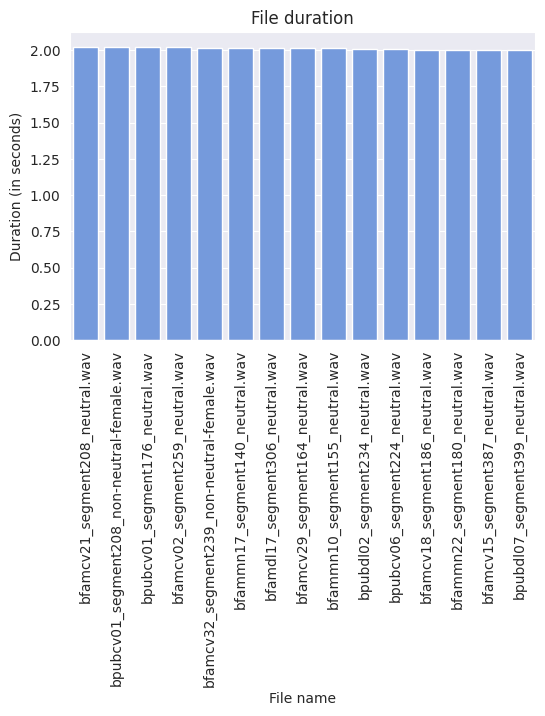

In [31]:
plot_file_duration(propor_train_df, top_n=-15)

In [32]:
propor_test_path = "/media/greca/HD/Datasets/PROPOR 2022/test_ser_metadata.csv"
propor_test_audio_path = "/media/greca/HD/Datasets/PROPOR 2022/test_ser"
propor_test_df = pd.read_csv(propor_test_path, sep=",")
propor_test_df["wav_file"] = propor_test_df["wav_file"].apply(lambda x: os.path.join(propor_test_audio_path, x))
propor_test_df.head()

,file,label,wav_file
0,bfamcv32_segment244_neutral.wav,neutral,/media/greca/HD/Datasets/PROPOR 2022/test_ser/...
1,bfamcv05_segment338_neutral.wav,neutral,/media/greca/HD/Datasets/PROPOR 2022/test_ser/...
2,bpubcv01_segment300_neutral.wav,neutral,/media/greca/HD/Datasets/PROPOR 2022/test_ser/...
3,bfamcv29_segment258_neutral.wav,neutral,/media/greca/HD/Datasets/PROPOR 2022/test_ser/...
4,bpubdl07_segment234_neutral.wav,neutral,/media/greca/HD/Datasets/PROPOR 2022/test_ser/...


In [33]:
propor_rates = check_sample_rates(
    df=propor_test_df
)

propor_rates_unique = list(set(list(propor_rates.keys())))

if len(propor_rates_unique) == 1:
    print(f"Sample rate of {propor_rates_unique[0]} found!")
else:
    print(f"Different sample were rates found! {propor_rates_unique}")

Error in file bfamcv32_segment244_neutral.wav
Error in file bfamcv05_segment338_neutral.wav
Error in file bpubcv01_segment300_neutral.wav
Error in file bfamcv29_segment258_neutral.wav
Error in file bpubdl07_segment234_neutral.wav
Error in file bfamdl24_segment152_neutral.wav
Error in file bpubmn12_segment103_neutral.wav
Error in file bfammn14_segment649_neutral.wav
Error in file bfamdl21_segment293_neutral.wav
Error in file bfamcv29_segment168_neutral.wav
Error in file bfamcv19_segment299_non-neutral-female.wav
Error in file bfamcv28_segment329_neutral.wav
Error in file bfamcv04_segment471_neutral.wav
Error in file bfamdl16_segment374_non-neutral-female.wav
Error in file bpubcv06_segment146_non-neutral-female.wav
Error in file bfammn28_segment106_neutral.wav
Error in file bpubcv02_segment190_neutral.wav
Error in file bfamcv14_segment197_non-neutral-female.wav
Error in file bfamdl05_segment391_neutral.wav
Error in file bfamdl17_segment227_neutral.wav
Error in file bfammn03_segment218_ne

In [34]:
propor_num_channels = check_number_of_channels(
    df=propor_test_df
)

propor_unique_num_channels = list(set(list(propor_num_channels.keys())))

if len(propor_unique_num_channels) == 1:
    print(f"The files are {propor_unique_num_channels[0]}!")
else:
    print(f"Both stereo and mono audios were found!")

Error in file bfamcv32_segment244_neutral.wav
Error in file bfamcv05_segment338_neutral.wav
Error in file bpubcv01_segment300_neutral.wav
Error in file bfamcv29_segment258_neutral.wav
Error in file bpubdl07_segment234_neutral.wav
Error in file bfamdl24_segment152_neutral.wav
Error in file bpubmn12_segment103_neutral.wav
Error in file bfammn14_segment649_neutral.wav
Error in file bfamdl21_segment293_neutral.wav
Error in file bfamcv29_segment168_neutral.wav
Error in file bfamcv19_segment299_non-neutral-female.wav
Error in file bfamcv28_segment329_neutral.wav
Error in file bfamcv04_segment471_neutral.wav
Error in file bfamdl16_segment374_non-neutral-female.wav
Error in file bpubcv06_segment146_non-neutral-female.wav
Error in file bfammn28_segment106_neutral.wav
Error in file bpubcv02_segment190_neutral.wav
Error in file bfamcv14_segment197_non-neutral-female.wav
Error in file bfamdl05_segment391_neutral.wav
Error in file bfamdl17_segment227_neutral.wav
Error in file bfammn03_segment218_ne

In [35]:
propor_test_df["label"] = propor_test_df["label"].replace({
    "neutral": "neutro",
    "non-neutral-male": "homem não-neutro",
    "non-neutral-female": "mulher não-neutro"
})

propor_test_df.head()

,file,label,wav_file
0,bfamcv32_segment244_neutral.wav,neutro,/media/greca/HD/Datasets/PROPOR 2022/test_ser/...
1,bfamcv05_segment338_neutral.wav,neutro,/media/greca/HD/Datasets/PROPOR 2022/test_ser/...
2,bpubcv01_segment300_neutral.wav,neutro,/media/greca/HD/Datasets/PROPOR 2022/test_ser/...
3,bfamcv29_segment258_neutral.wav,neutro,/media/greca/HD/Datasets/PROPOR 2022/test_ser/...
4,bpubdl07_segment234_neutral.wav,neutro,/media/greca/HD/Datasets/PROPOR 2022/test_ser/...


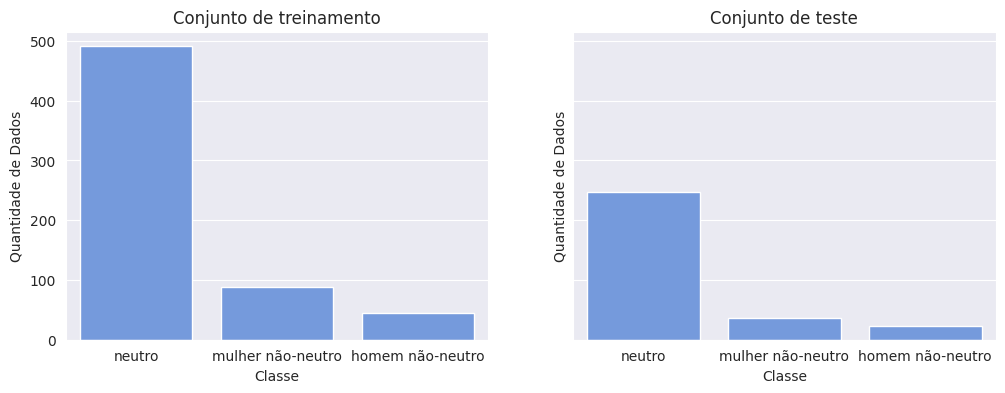

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)

df_gby_train = propor_train_df.groupby("label").agg({"wav_file": "count"})
df_gby_train = df_gby_train.reset_index()
df_gby_train = df_gby_train.sort_values("label", ascending=False)
df_gby_train = df_gby_train.reset_index()

df_gby_test = propor_test_df.groupby("label").agg({"wav_file": "count"})
df_gby_test = df_gby_test.reset_index()
df_gby_test = df_gby_test.sort_values("label", ascending=False)
df_gby_test = df_gby_test.reset_index()

sns.barplot(
    data=df_gby_train,
    x="label",
    y="wav_file",
    color="cornflowerblue",
    ax=ax1
)
ax1.set_title("Conjunto de treinamento")
ax1.set_ylabel("Quantidade de Dados")
ax1.set_xlabel("Classe")

sns.barplot(
    data=df_gby_test,
    x="label",
    y="wav_file",
    color="cornflowerblue",
    ax=ax2
)
ax2.set_title("Conjunto de teste")
ax2.set_ylabel("Quantidade de Dados")
ax2.set_xlabel("Classe")
plt.savefig("../images/distribuição_coraa.png")

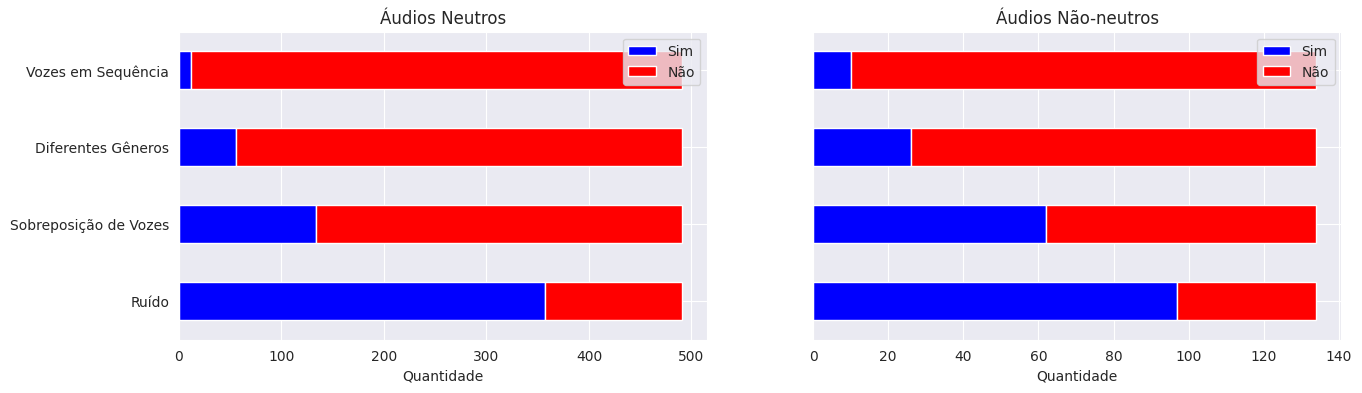

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4), sharex=False, sharey=True)

df = pd.DataFrame({
    "Sim": [357, 134, 56, 12],
    "Não": [134, 357, 435, 479]
}, index=["Ruído", "Sobreposição de Vozes", "Diferentes Gêneros", "Vozes em Sequência"])

df.plot(kind="barh", stacked=True, color=["blue", "red"], ax=ax1)
ax1.set_xlabel("Quantidade")
ax1.set_title("Áudios Neutros")
ax1.legend(loc="best")

df = pd.DataFrame({
    "Sim": [97, 62, 26, 10],
    "Não": [37, 72, 108, 124]
}, index=["Ruído", "Sobreposição de Vozes", "Diferentes Gêneros", "Vozes em Sequência"])

df.plot(kind="barh", stacked=True, color=["blue", "red"], ax=ax2)
ax2.set_xlabel("Quantidade")
ax2.set_title("Áudios Não-neutros")
ax2.legend(loc="best")

plt.savefig("../images/grafico_adaptado_coraa.png")

In [38]:
propor_test_df = get_duration(
    df=propor_test_df
)

print(sum(propor_test_df["duration"])/60)

FileNotFoundError: [Errno 2] No such file or directory: 'bfamcv32_segment244_neutral.wav'

In [ ]:
plot_file_duration(propor_test_df, top_n=15)

In [ ]:
plot_file_duration(propor_test_df, top_n=-15)